In [1]:
# for running in collab, sagemaker etc.
import sys
import os

def _append_sys_path_of_utils():
    """
    Appends an utils directory to a system path so it is visible for the script.
    """
    UTILS_RELATIVE_PATH = "../../utils/"

    absolute_path_of_utils = os.path.abspath(UTILS_RELATIVE_PATH)
    if absolute_path_of_utils:
        if absolute_path_of_utils in sys.path:
            print(f"Absolute path already in sys.path: {absolute_path_of_utils}")
        else:
            print(f"Appended absolute path: {absolute_path_of_utils}")
            sys.path.insert(0, absolute_path_of_utils)
    else:
        print("Absolute path of utils module not found.")


_append_sys_path_of_utils()

Appended absolute path: /home/studio-lab-user/Generative_Models_for_CERN_Fast_Simulations/utils


In [1]:
import wandb

In [2]:
!wandb login

wandb: Currently logged in as: bedkowski-patrick (nlp-wut-2023). Use `wandb login --relogin` to force relogin


In [3]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tensorflow.keras import layers
import pickle
import time
from numpy import load
from matplotlib import pyplot
import pickle
import argparse

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

from scipy.stats import wasserstein_distance
import pandas as pd
from utils.utils import sum_channels_parallel as sum_channels_parallel
from sklearn.metrics import mean_absolute_error
from datetime import datetime

2.10.1


In [5]:
SAVE_EXPERIMENT_DATA = True

### Load and process data

In [6]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
import sklearn
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [7]:
data = pd.read_pickle('../../data/data_proton_20_2312_neutron_20_3360_padded.pkl')
print('Loaded: ',  data.shape, "max:", data.max())

data_cond = pd.read_pickle('../../data/data_cond_stddev_photonsum_20_2312_20_3360_padded.pkl')
print('Loaded cond: ',  data_cond.shape, "max:", data_cond.values.max(), "min:", data_cond.values.min())

Loaded:  (32951, 56, 44, 2) max: 603.0
Loaded cond:  (32951, 15) max: 7000.0 min: -7000.0


In [8]:
# calculate min max proton, neutron sum
photon_sum_proton_min, photon_sum_proton_max = data_cond.proton_photon_sum.min(), data_cond.proton_photon_sum.max()
photon_sum_neutron_min, photon_sum_neutron_max = data_cond.neutron_photon_sum.min(), data_cond.neutron_photon_sum.max()

In [9]:
data_cond.drop(columns=['proton_photon_sum', 'neutron_photon_sum', 'group_number_proton', 'group_number_neutron'], inplace=True)
data_cond.columns, len(data_cond.columns)

(Index(['Energy', 'Vx', 'Vy', 'Vz', 'Px', 'Py', 'Pz', 'mass', 'charge',
        'std_proton', 'std_neutron'],
       dtype='object'),
 11)

In [10]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge,std_proton,std_neutron
0,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0,0.477884,0.131516
1,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0,0.097154,0.716880
2,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0,0.132449,0.266155
3,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0,0.104508,0.364880
4,4144.25,0.000000e+00,0.000000e+00,0.000000e+00,0.339171,1.352870,-4144.24,939.565413,0.0,0.074378,0.315074


In [11]:
STRENGTH = 0.1

DATE_STR = datetime.now().strftime("%d_%m_%Y_%H_%M")

NAME = "sdi-gan-padded"

wandb_run_name = f"{int(photon_sum_proton_min)}_{int(photon_sum_proton_max)}_{DATE_STR}"

EXPERIMENT_DIR_NAME = f"experiments/{NAME}_{int(photon_sum_proton_min)}_{int(photon_sum_proton_max)}_{DATE_STR}"

print("Experiment DIR: ", EXPERIMENT_DIR_NAME)

Experiment DIR:  experiments/sdi-gan-padded_20_1970_06_07_2023_14_24


In [12]:
def create_dir(path):
    if SAVE_EXPERIMENT_DATA:
        isExist = os.path.exists(path)
        if not isExist:
            os.makedirs(path)

In [13]:
def save_scales(model_name, scaler_means, scaler_scales):
    out_fnm = f"{model_name}_scales.txt"
    res = "#means"
    for mean_ in scaler_means:
        res += "\n" + str(mean_)
    res += "\n\n#scales"
    for scale_ in scaler_scales:
        res += "\n" + str(scale_)

    if SAVE_EXPERIMENT_DATA:
        filepath = f"../../{EXPERIMENT_DIR_NAME}/scales/"
        create_dir(filepath)
        with open(filepath+out_fnm, mode="w") as f:
            f.write(res)

In [14]:
data_cond["cond"] = data_cond["Energy"].astype(str) +"|"+ data_cond["Vx"].astype(str) +"|"+  data_cond["Vy"].astype(str) +"|"+ data_cond["Vz"].astype(str) +"|"+  data_cond["Px"].astype(str) +"|"+  data_cond["Py"].astype(str) +"|"+ data_cond["Pz"].astype(str) +"|"+  data_cond["mass"].astype(str) +"|"+  data_cond["charge"].astype(str)
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge,std_proton,std_neutron,cond
0,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0,0.477884,0.131516,3961.55|0.0|0.0|0.0|-0.0764874|0.179845|3961.5...
1,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0,0.097154,0.716880,2770.1|1.86117e-17|2.5171900000000004e-17|-1.6...
2,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0,0.132449,0.266155,3195.12|0.0|0.0|0.0|0.560528|-0.14998|3195.11|...
3,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0,0.104508,0.364880,1714.07|0.0|0.0|0.0|0.457768|0.145639000000000...
4,4144.25,0.000000e+00,0.000000e+00,0.000000e+00,0.339171,1.352870,-4144.24,939.565413,0.0,0.074378,0.315074,4144.25|0.0|0.0|0.0|0.339171|1.35287|-4144.24|...


In [15]:
data_cond_id = data_cond[["cond"]].reset_index()
data_cond_id

,index,cond
0,0,3961.55|0.0|0.0|0.0|-0.0764874|0.179845|3961.5...
1,1,2770.1|1.86117e-17|2.5171900000000004e-17|-1.6...
2,2,3195.12|0.0|0.0|0.0|0.560528|-0.14998|3195.11|...
3,3,1714.07|0.0|0.0|0.0|0.457768|0.145639000000000...
4,4,4144.25|0.0|0.0|0.0|0.339171|1.35287|-4144.24|...
...,...,...
32946,32946,1456.66|7.79676e-18|2.26923e-18|-4.06504e-14|0...
32947,32947,3812.18|0.0|0.0|0.0|0.0529534|0.402807|-3812.1...
32948,32948,1422.39|1.1825599999999999e-05|-1.3857e-06|0.0...
32949,32949,4071.23|0.0|0.0|0.0|0.089305|0.0694104|-4071.2...


In [16]:
# select a random index of the same conditional data
# shuffle the data and merge it according to the conditional data. Pick the first index of the grouped conditional data
# if some unique conditional data has only one index of sample, then pair it with the same index 
ids = data_cond_id.merge(data_cond_id.sample(frac=1), on=["cond"], how="inner").groupby("index_x").first()
ids = ids["index_y"]
ids

index_x
0        31497
1         2912
2         3044
3         3573
4        26635
         ...  
32946    16591
32947    16662
32948    30013
32949     7720
32950    18091
Name: index_y, Length: 32951, dtype: int64

### Idea
Eliminate samples that are unique in terms of conditional data leaving only these responses that have few samples grouped by condtional data

Now we will have two conditional datasets and two response datasets

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
data_cond

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge,std_proton,std_neutron,cond
0,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0,0.477884,0.131516,3961.55|0.0|0.0|0.0|-0.0764874|0.179845|3961.5...
1,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0,0.097154,0.716880,2770.1|1.86117e-17|2.5171900000000004e-17|-1.6...
2,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0,0.132449,0.266155,3195.12|0.0|0.0|0.0|0.560528|-0.14998|3195.11|...
3,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0,0.104508,0.364880,1714.07|0.0|0.0|0.0|0.457768|0.145639000000000...
4,4144.25,0.000000e+00,0.000000e+00,0.000000e+00,0.339171,1.352870,-4144.24,939.565413,0.0,0.074378,0.315074,4144.25|0.0|0.0|0.0|0.339171|1.35287|-4144.24|...
...,...,...,...,...,...,...,...,...,...,...,...,...
32946,1456.66,7.796760e-18,2.269230e-18,-4.065040e-14,0.279388,0.081315,-1456.66,497.611000,0.0,0.064568,0.598369,1456.66|7.79676e-18|2.26923e-18|-4.06504e-14|0...
32947,3812.18,0.000000e+00,0.000000e+00,0.000000e+00,0.052953,0.402807,-3812.18,938.272081,1.0,0.365061,0.148777,3812.18|0.0|0.0|0.0|0.0529534|0.402807|-3812.1...
32948,1422.39,1.182560e-05,-1.385700e-06,3.655780e-02,0.511508,-0.052227,1422.39,0.000000,0.0,0.048795,0.100312,1422.39|1.1825599999999999e-05|-1.3857e-06|0.0...
32949,4071.23,0.000000e+00,0.000000e+00,0.000000e+00,0.089305,0.069410,-4071.23,1115.683000,0.0,0.491409,0.841660,4071.23|0.0|0.0|0.0|0.089305|0.0694104|-4071.2...


In [19]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

data_2 = data[ids]

data_cond = data_cond.drop(columns="cond")

scaler_proton = MinMaxScaler()
std_proton = data_cond["std_proton"].values.reshape(-1,1)
std_proton = np.float32(std_proton)
std_proton = scaler_proton.fit_transform(std_proton)
print("std max", std_proton.max(), "min", std_proton.min())

scaler_neutron = MinMaxScaler()
std_neutron = data_cond["std_neutron"].values.reshape(-1,1)
std_neutron = np.float32(std_neutron)
std_neutron = scaler_neutron.fit_transform(std_neutron)
print("std max", std_neutron.max(), "min", std_neutron.min())

data max 6.403574 min 0.0
std max 1.0 min 0.0
std max 1.0 min 0.0


In [20]:
scaler = StandardScaler()
data_cond = np.float32(data_cond.drop(columns=["std_proton", "std_neutron"]))
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

cond max 38.509796 min -82.6031


In [21]:
data_2.shape

(32951, 56, 44, 2)

In [22]:
x_train, x_test, x_train_2, x_test_2, y_train, y_test, std_proton_train, std_proton_test, std_neutron_train, std_neutron_test = train_test_split(data, data_2, data_cond, std_proton, std_neutron, test_size=0.2, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, std_proton_train.shape, std_proton_test.shape, std_neutron_train.shape, std_neutron_test.shape)

(26360, 56, 44, 2) (6591, 56, 44, 2) (26360, 9) (6591, 9) (26360, 1) (6591, 1) (26360, 1) (6591, 1)


In [23]:
#save scales
if SAVE_EXPERIMENT_DATA:
    save_scales("Proton", scaler.mean_, scaler.scale_)

In [24]:
BATCH_SIZE = 128

# Training dataset

# datasets that in each index contain two samples from the same conditional data
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=BATCH_SIZE)
dataset_2 = tf.data.Dataset.from_tensor_slices(x_train_2).batch(batch_size=BATCH_SIZE)
# conditional data
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=BATCH_SIZE)
# standard deviation for each conditional data samples
dataset_std_proton = tf.data.Dataset.from_tensor_slices(std_proton_train).batch(batch_size=BATCH_SIZE)
dataset_std_neutron = tf.data.Dataset.from_tensor_slices(std_neutron_train).batch(batch_size=BATCH_SIZE)
# shuffled conditional data
fake_cond =  tf.data.Dataset.from_tensor_slices(y_train).shuffle(12800).batch(batch_size=BATCH_SIZE)

# zipped data
dataset_with_cond = tf.data.Dataset.zip((dataset, dataset_2, dataset_cond, dataset_std_proton, dataset_std_neutron, fake_cond)).shuffle(12800)

# Validation dataset

val_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size=BATCH_SIZE)
val_dataset_2 = tf.data.Dataset.from_tensor_slices(x_test_2).batch(batch_size=BATCH_SIZE)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=BATCH_SIZE)
val_dataset_std_proton = tf.data.Dataset.from_tensor_slices(std_proton_test).batch(batch_size=BATCH_SIZE)
val_dataset_std_neutron = tf.data.Dataset.from_tensor_slices(std_neutron_test).batch(batch_size=BATCH_SIZE)
val_fake_cond =  tf.data.Dataset.from_tensor_slices(y_test).shuffle(12800).batch(batch_size=BATCH_SIZE)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset, val_dataset_2, val_dataset_cond, val_dataset_std_proton, val_dataset_std_neutron, val_fake_cond)).shuffle(12800)

### Define Model

In [25]:
from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from tensorflow import keras

In [26]:
latent_dim = 10
cond_dim = 9

############################ generator ############################

x = Input(shape=(latent_dim,))
cond = Input(shape=(cond_dim,))
inputs = Concatenate(axis=1)([x, cond])

layer_1 = Dense(64*2)(inputs)
layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

layer_2 = Dense(64*20*12)(layer_1_a)
layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)

reshaped = Reshape((20,12,64))(layer_2_a)
reshaped_s = UpSampling2D(size=(3,2))(reshaped)

conv1 = Conv2D(128, kernel_size=(2, 2), padding='valid')(reshaped_s)
conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
conv1_a_s = UpSampling2D(size=(1,2))(conv1_a)

conv2 = Conv2D(64, kernel_size=2)(conv1_a_s)
conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)

outputs = Conv2D(2, kernel_size=(3, 2), activation='relu')(conv2_a)

generator = Model([x, cond], outputs, name='generator')
generator.summary()

############################ discriminator ############################

input_img = Input(shape=[56,44,2],name='input_img')
conv1 = Conv2D(16, kernel_size=3)(input_img)
conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_a)

conv2 = Conv2D(8, kernel_size=3)(pool1)
conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
pool2 = MaxPooling2D(pool_size=(2, 1))(conv2_a)

flat = Flatten()(pool2)
cond = Input(shape=(cond_dim,))
inputs2 = Concatenate(axis=1)([flat, cond])
layer_1 = Dense(32)(inputs2)
layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

layer_2 = Dense(16)(layer_1_a)
layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)
outputs = Dense(1, activation='sigmoid')(layer_2_a)

discriminator = Model([input_img, cond], [outputs, layer_2_a], name='discriminator')
discriminator.summary()


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 19)           0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 128)          2560        ['concatenate[0][0]']    

### Idea
Increase number of latent dimensions with the old architecture

In [27]:
# # architecture 4

# latent_dim = 20
# cond_dim = 9

# ############################ generator ############################

# x = Input(shape=(latent_dim,))
# cond = Input(shape=(cond_dim,))
# inputs = Concatenate(axis=1)([x, cond])

# layer_1 = Dense(256*2)(inputs)
# layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
# layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

# layer_2 = Dense(256*16*12)(layer_1_a)
# layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
# layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)

# reshaped = Reshape((16,12,256))(layer_2_a)
# reshaped_s = UpSampling2D(size=(4, 2))(reshaped)

# conv1 = Conv2D(256, kernel_size=(3, 2), padding='valid')(reshaped_s)
# conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
# conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
# conv1_a_s = UpSampling2D(size=(1, 2))(conv1_a)

# conv2 = Conv2D(128, kernel_size=(4, 2))(conv1_a_s)
# conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
# conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)

# conv3 = Conv2D(64, kernel_size=(1, 2))(conv2_a)
# conv3_bd = Dropout(0.2)(BatchNormalization()(conv3))
# conv3_a = LeakyReLU(alpha=0.1)(conv3_bd)

# outputs = Conv2D(2, kernel_size=(4, 1), activation='relu')(conv3_a)

# generator = Model([x, cond], outputs, name='generator')
# generator.summary()

# ############################ discriminator ############################

# input_img = Input(shape=[56, 44, 2], name='input_img')
# conv1 = Conv2D(64, kernel_size=3)(input_img)
# conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
# conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
# pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_a)

# conv2 = Conv2D(32, kernel_size=3)(pool1)
# conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
# conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
# pool2 = MaxPooling2D(pool_size=(2, 1))(conv2_a)

# flat = Flatten()(pool2)
# cond = Input(shape=(cond_dim,))

# inputs2 = Concatenate(axis=1)([flat, cond])
# layer_1 = Dense(128)(inputs2)
# layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
# layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

# layer_2 = Dense(64)(layer_1_a)
# layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
# layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)

# outputs = Dense(2, activation='sigmoid')(layer_2_a)

# discriminator = Model([input_img, cond], [outputs, layer_2_a], name='discriminator')
# discriminator.summary()

In [28]:
# # architecture 3

# latent_dim = 16
# cond_dim = 9

# ############################ generator ############################

# x = Input(shape=(latent_dim,))
# cond = Input(shape=(cond_dim,))
# inputs = Concatenate(axis=1)([x, cond])

# layer_1 = Dense(128*2)(inputs)
# layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
# layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

# layer_2 = Dense(128*16*12)(layer_1_a)
# layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
# layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)

# reshaped = Reshape((16,12,128))(layer_2_a)
# reshaped_s = UpSampling2D(size=(4, 2))(reshaped)

# conv1 = Conv2D(256, kernel_size=(3, 2), padding='valid')(reshaped_s)
# conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
# conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
# conv1_a_s = UpSampling2D(size=(1, 2))(conv1_a)

# conv2 = Conv2D(128, kernel_size=(4, 2))(conv1_a_s)
# conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
# conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)

# conv3 = Conv2D(64, kernel_size=(1, 2))(conv2_a)
# conv3_bd = Dropout(0.2)(BatchNormalization()(conv3))
# conv3_a = LeakyReLU(alpha=0.1)(conv3_bd)

# outputs = Conv2D(2, kernel_size=(4, 1), activation='relu')(conv3_a)

# generator = Model([x, cond], outputs, name='generator')
# generator.summary()

# ############################ discriminator ############################

# input_img = Input(shape=[56, 44, 2], name='input_img')
# conv1 = Conv2D(64, kernel_size=3)(input_img)
# conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
# conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
# pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_a)

# conv2 = Conv2D(32, kernel_size=3)(pool1)
# conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
# conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
# pool2 = MaxPooling2D(pool_size=(2, 1))(conv2_a)

# flat = Flatten()(pool2)
# cond = Input(shape=(cond_dim,))

# inputs2 = Concatenate(axis=1)([flat, cond])
# layer_1 = Dense(128)(inputs2)
# layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
# layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

# layer_2 = Dense(64)(layer_1_a)
# layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
# layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)

# outputs = Dense(2, activation='sigmoid')(layer_2_a)

# discriminator = Model([input_img, cond], [outputs, layer_2_a], name='discriminator')
# discriminator.summary()

In [29]:
# Second bigger architecture
# latent_dim = 20
# cond_dim = 9

# ############################ generator ############################

# x = Input(shape=(latent_dim,))
# cond = Input(shape=(cond_dim,))
# inputs = Concatenate(axis=1)([x, cond])

# layer_1 = Dense(256*2)(inputs)
# layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
# layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

# layer_2 = Dense(256*16*12)(layer_1_a)
# layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
# layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)

# reshaped = Reshape((16,12,256))(layer_2_a)
# reshaped_s = UpSampling2D(size=(4, 2))(reshaped)

# conv1 = Conv2D(512, kernel_size=(3, 2), padding='valid')(reshaped_s)
# conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
# conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
# conv1_a_s = UpSampling2D(size=(1, 2))(conv1_a)

# conv2 = Conv2D(256, kernel_size=(4, 2))(conv1_a_s)
# conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
# conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)

# conv3 = Conv2D(128, kernel_size=(1, 2))(conv2_a)
# conv3_bd = Dropout(0.2)(BatchNormalization()(conv3))
# conv3_a = LeakyReLU(alpha=0.1)(conv3_bd)

# outputs = Conv2D(2, kernel_size=(4, 1), activation='relu')(conv3_a)

# generator = Model([x, cond], outputs, name='generator')
# generator.summary()

# ############################ discriminator ############################

# input_img = Input(shape=[56, 44, 2],name='input_img')
# conv1 = Conv2D(64, kernel_size=3)(input_img)
# conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
# conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
# pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_a)

# conv2 = Conv2D(128, kernel_size=3)(pool1)
# conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
# conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
# pool2 = MaxPooling2D(pool_size=(2, 1))(conv2_a)

# flat = Flatten()(pool2)
# cond = Input(shape=(cond_dim,))

# inputs2 = Concatenate(axis=1)([flat, cond])
# layer_1 = Dense(64)(inputs2)
# layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
# layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

# layer_2 = Dense(32)(layer_1_a)
# layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
# layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)

# outputs = Dense(2, activation='sigmoid')(layer_2_a)

# discriminator = Model([input_img, cond], [outputs, layer_2_a], name='discriminator')
# discriminator.summary()

In [30]:
# # OLD architecture
# latent_dim = 20
# cond_dim = 10

# ############################ generator ############################

# x = Input(shape=(latent_dim,))
# cond = Input(shape=(cond_dim,))
# inputs = Concatenate(axis=1)([x, cond])

# layer_1 = Dense(128*2)(inputs)
# layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
# layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

# layer_2 = Dense(128*28*22)(layer_1_a)
# layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
# layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)

# reshaped = Reshape((28, 22, 128))(layer_2_a)
# # reshaped_s = UpSampling2D()(reshaped)

# conv1 = Conv2D(128, kernel_size=1)(reshaped)
# conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
# conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
# conv1_a_s = UpSampling2D()(conv1_a)

# conv2 = Conv2D(64, kernel_size=1)(conv1_a_s)
# conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
# conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)

# outputs = Conv2D(1, kernel_size=1,activation='relu')(conv2_a)

# generator = Model([x, cond], outputs, name='generator')
# generator.summary()

# ############################ discriminator ############################

# input_img = Input(shape=[56,44,2],name='input_img')
# conv1 = Conv2D(32, kernel_size=3)(input_img)
# conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
# conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
# pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_a)
# conv2 = Conv2D(16, kernel_size=3)(pool1)
# conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
# conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_a)
# flat = Flatten()(pool2)
# cond = Input(shape=(cond_dim,))

# inputs2 = Concatenate(axis=1)([flat, cond])
# layer_1 = Dense(128)(inputs2)
# layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
# layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)
# layer_2 = Dense(64)(layer_1_a)
# layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
# layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)
# outputs = Dense(1, activation='sigmoid')(layer_2_a)

# discriminator = Model([input_img, cond], outputs, name='discriminator')
# discriminator.summary()

### IDEA
Why do we only take into account a loss of only single generated image

In [31]:
# def discriminator_loss(real_output, fake_output, fake_output_2):
#     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#     fake_loss_2 = cross_entropy(tf.zeros_like(fake_output_2), fake_output_2)
#     total_loss = real_loss + fake_loss + fake_loss_2
    
#     # update state of accuracy of real and false images
#     d_acc_r.update_state(tf.ones_like(real_output), real_output)
#     d_acc_f.update_state(tf.zeros_like(fake_output), fake_output)
#     return total_loss

In [32]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    # update state of accuracy of real and false images
    d_acc_r.update_state(tf.ones_like(real_output), real_output)
    d_acc_f.update_state(tf.zeros_like(fake_output), fake_output)
    return total_loss

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [34]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
d_acc_r = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
d_acc_f = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
g_acc = keras.metrics.BinaryAccuracy(name="g_acc_g", threshold=0.5)

### IDEA
Why do we only take into accoutn a single genrated image, not from two latent codes

In [35]:
# def generator_loss(step, fake_output, fake_output_2,
#                    fake_latent, fake_latent_2,
#                    noise, noise_2,
#                    std_proton, std_neutron):

#     g_acc.update_state(tf.ones_like(fake_output), fake_output)
#     g_acc.update_state(tf.ones_like(fake_output_2), fake_output_2)

#     crossentropy_loss = cross_entropy(tf.ones_like(fake_output), fake_output) + cross_entropy(tf.ones_like(fake_output_2), fake_output_2)

#     div = tf.math.divide(tf.reduce_mean(tf.abs(fake_latent - fake_latent_2),(1)), tf.reduce_mean(tf.abs(noise-noise_2),(1)))

#     div_loss_proton = std_proton * STRENGTH / (div + 1e-5)
#     div_loss_neutron = std_neutron * STRENGTH / (div + 1e-5)

#     div_loss_proton = tf.reduce_mean(tf.math.multiply(tf.reduce_mean(std_proton,(1)), div_loss_proton))
#     div_loss_neutron = tf.reduce_mean(tf.math.multiply(tf.reduce_mean(std_neutron,(1)), div_loss_neutron))
#     div_loss = div_loss_proton + div_loss_neutron
#     return crossentropy_loss + div_loss, div_loss

### IDEA
Should we take mean of diversity loss or just sum the up?

In [36]:
def generator_loss(step, fake_output,
                   fake_latent, fake_latent_2,
                   noise, noise_2,
                   std_proton, std_neutron):

    g_acc.update_state(tf.ones_like(fake_output), fake_output)

    crossentropy_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    div = tf.math.divide(tf.reduce_mean(tf.abs(fake_latent - fake_latent_2),(1)), tf.reduce_mean(tf.abs(noise-noise_2),(1)))

    div_loss_proton = std_proton * STRENGTH / (div + 1e-5)
    div_loss_neutron = std_neutron * STRENGTH / (div + 1e-5)

    div_loss_proton = tf.reduce_mean(tf.math.multiply(tf.reduce_mean(std_proton,(1)), div_loss_proton))
    div_loss_neutron = tf.reduce_mean(tf.math.multiply(tf.reduce_mean(std_neutron,(1)), div_loss_neutron))

    # average diversity loss
    div_loss = div_loss_proton + div_loss_neutron
    return crossentropy_loss + div_loss, div_loss

In [37]:
EPOCHS = 200
noise_dim = latent_dim
num_examples_to_generate = 16

START_GENERATING_IMG_FROM_IDX = 20
# Seed to reuse for generating samples for comparison during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = y_test[START_GENERATING_IMG_FROM_IDX:START_GENERATING_IMG_FROM_IDX+num_examples_to_generate]

In [38]:
wandb.finish()
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Generative Models for CERN Fast Simulations",
    name=wandb_run_name,
    # track hyperparameters and run metadata
    config={
    "Model": NAME,
    "dataset": "proton_neutron_data",
    "epochs": EPOCHS,
    "Date": DATE_STR,
    "latent_dimension": latent_dim,
    "Proton_min": photon_sum_proton_min,
    "Proton_max": photon_sum_proton_max,
    "Experiment_dir_name": EXPERIMENT_DIR_NAME,
    "batch_size": BATCH_SIZE
    },
    tags=[f"proton_min_{photon_sum_proton_min}",
          f"proton_max_{photon_sum_proton_max}",
          f"neutron_min_{photon_sum_neutron_min}",
          f"neutron_max_{photon_sum_neutron_max}",
          f"gan_strength_{STRENGTH}", "sdi-gan"]
)

wandb: Currently logged in as: bedkowski-patrick (nlp-wut-2023). Use `wandb login --relogin` to force relogin


In [39]:
from scipy.stats import wasserstein_distance
import pandas as pd
from utils.utils import sum_channels_parallel
from sklearn.metrics import mean_absolute_error

org=np.exp(x_test)-1
ch_org = np.array(org).reshape(-1,56,44)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values
del org


def calculate_ws_ch(n_calc):
    ws= [0,0,0,0,0]
    for j in range(n_calc):
        z = np.random.normal(0,1,(x_test.shape[0],latent_dim))
        z_c = y_test
        results = generator.predict([z,z_c])
        results = np.exp(results)-1
        try:
            ch_gen = np.array(results).reshape(-1,56,44)
            ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
            for i in range(5):
                ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
            ws =np.array(ws)
        except ValueError as e:
            print(e)

    ws = ws/n_calc
    ws_mean = ws.sum()/5
    print("ws mean",f'{ws_mean:.2f}', end=" ")
    for n, score in enumerate(ws):
        print("ch"+str(n+1),f'{score:.2f}',end=" ")
    return ws_mean


In [40]:
@tf.function
def train_step(batch, step):
    # dataset, dataset_2, dataset_cond, dataset_std_proton, dataset_std_neutron, fake_cond
    images, images_2, cond, std_proton, std_neutron, noise_cond = batch
    step=step
    BATCH_SIZE = tf.shape(images)[0]
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    noise_2 = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # for the same conditional data generate two images from different noises
        generated_images = generator([noise, noise_cond], training=True)
        generated_images_2 = generator([noise_2, noise_cond], training=True)
        
        # produce if real image is real or fake
        real_output, real_latent = discriminator([images, cond], training=True)
        # real_output_2,real_latent_2  = discriminator([images_2,cond], training=True)
        
        # produce if generated images from two different latent codes are real or fake
        fake_output, fake_latent = discriminator([generated_images, noise_cond], training=True)
        fake_output_2, fake_latent_2 = discriminator([generated_images_2, noise_cond], training=True)

        gen_loss, div_loss = generator_loss(step, fake_output,
                                            fake_latent, fake_latent_2,
                                            noise, noise_2,
                                            std_proton, std_neutron)
        disc_loss = discriminator_loss(real_output, fake_output)


    #         generated_images = generator([noise,noise_cond], training=True)

    #         real_output = discriminator([images,cond], training=True)
    #         fake_output = discriminator([generated_images, noise_cond], training=True)

    #         gen_loss = generator_loss(step, fake_output)
    #         real_loss, fake_loss = discriminator_loss(real_output, fake_output)
    #         disc_loss = real_loss + fake_loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, div_loss


In [41]:
# If model achieves WS metric less or equal to this number, its weights will be saved
WS_MEAN_SAVE_THRESHOLD = 20


if SAVE_EXPERIMENT_DATA:
    filepath_mod = f"../../{EXPERIMENT_DIR_NAME}/models/"
    create_dir(filepath_mod)

history = []
def train(dataset, epochs):
    experiment_start = time.time()
    tf_step = tf.Variable(0, dtype=float)
    step=0

    # generate first image
    generate_and_save_images(generator,
                             epochs,
                             [seed, seed_cond])

    for epoch in range(epochs):
        start = time.time()

        gen_loss_epoch = []
        div_loss_epoch = []
        disc_loss_epoch = []
        for batch in dataset:
            gen_loss, disc_loss, div_loss =train_step(batch,tf_step)

            history.append([gen_loss,disc_loss,
                100*d_acc_r.result().numpy(),
                100*d_acc_f.result().numpy(),
                100*g_acc.result().numpy(),
                ])
            tf_step.assign_add(1)
            step = step+1

            gen_loss_epoch.append(gen_loss)
            disc_loss_epoch.append(disc_loss)
            div_loss_epoch.append(div_loss)
            if step % 100 == 0:
                print("%d [D real acc: %.2f%%] [D fake acc: %.2f%%] [G acc: %.2f%%] "% (
                    step,
                    100*d_acc_r.result().numpy(),
                    100*d_acc_f.result().numpy(),
                    100*g_acc.result().numpy()))

        plot = generate_and_save_images(generator,
                                 epoch,
                                 [seed, seed_cond])

        ws_mean = calculate_ws_ch(min(epoch//5+1,5))

        if SAVE_EXPERIMENT_DATA:
            if ws_mean <= WS_MEAN_SAVE_THRESHOLD:
                # Save the model every epoch
                generator.compile()
                # discriminator.compile()
                generator.save((os.path.join(filepath_mod, "gen_"+NAME + "_"+ str(epoch) +".h5")))
                # discriminator.save((os.path.join(filepath_mod, "disc_"+NAME + "_"+ str(epoch) +".h5")))
                # np.savez(os.path.join(filepath_mod, "history_"+NAME+".npz"),np.array(history))

        wandb.log({
            'ws_mean': ws_mean,
            'gen_loss': np.mean(gen_loss_epoch),
            'div_loss': np.mean(div_loss_epoch),
            'disc_loss': np.mean(disc_loss_epoch),
            'epoch': epoch,
            'plot': wandb.Image(plot),
            'experiment_time': time.time()-experiment_start
        })

        plt.close('all')

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    return history

In [42]:
if SAVE_EXPERIMENT_DATA:
    filepath_img = f"../../{EXPERIMENT_DIR_NAME}/images/"
    create_dir(filepath_img)

    
def generate_and_save_images(model, epoch, test_input):
    START_INDEX = 6
    SUPTITLE_TXT = f"\nModel: GAN proton data" \
               f"\nPhotonsum interval: [{photon_sum_proton_min}, {photon_sum_proton_max}]" \
               f"\nEPOCH: {epoch}"

    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    """
    predictions has shape (n_samples, 56, 44, 2). First channel has proton data, second has neutrons
    """
    fig = plt.figure(figsize=(15,4))

    plt.title(f"EPOCH {epoch}")

    subfigs = fig.subfigures(1, 4)

    for particle_num, subfig in enumerate(subfigs.flat):  # iterate over 4 particles
        subfig.suptitle(f'Particle {particle_num} response')
        axs = subfig.subplots(2, 2)
        for i, ax in enumerate(axs.flat):  # iterate over 4 images of single particle
            m_2 = i % 2  # 0 if proton, 1 if neutron
            if i < 2:
                # Real response
                x = x_test[START_INDEX+particle_num][:,:,m_2].reshape(56,44)
                axs[i//2, m_2].set_title("neutron" if m_2 else "proton")
            else:
                # Generated response
                x = predictions[START_INDEX+particle_num].numpy()[:,:,m_2].reshape(56,44)
            axs[i//2, m_2].set_axis_off()
            im = axs[i//2, m_2].imshow(x, interpolation='none', cmap='gnuplot')
            fig.colorbar(im, ax=axs[i//2, m_2])

    if SAVE_EXPERIMENT_DATA:
        plt.savefig(os.path.join(filepath_img, 'image_at_epoch_{:04d}.png'.format(epoch)))
    
    return fig

### Train model

ResourceExhaustedError: Graph execution error:

Detected at node 'generator/dropout_1/dropout_1/random_uniform/RandomUniform' defined at (most recent call last):
    File "C:\Users\PB\.conda\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\PB\.conda\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\PB\.conda\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\PB\.conda\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\PB\.conda\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\PB\AppData\Local\Temp\ipykernel_20908\3105095798.py", line 1, in <module>
      history = train(dataset_with_cond, EPOCHS)
    File "C:\Users\PB\AppData\Local\Temp\ipykernel_20908\1959833039.py", line 27, in train
      gen_loss, disc_loss, div_loss =train_step(batch,tf_step)
    File "C:\Users\PB\AppData\Local\Temp\ipykernel_20908\1967024746.py", line 13, in train_step
      generated_images_2 = generator([noise_2, noise_cond], training=True)
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\keras\layers\regularization\dropout.py", line 116, in call
      output = control_flow_util.smart_cond(
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\keras\layers\regularization\dropout.py", line 112, in dropped_inputs
      return self._random_generator.dropout(
    File "C:\Users\PB\.conda\envs\tf\lib\site-packages\keras\backend.py", line 2162, in dropout
      return tf.nn.dropout(
Node: 'generator/dropout_1/dropout_1/random_uniform/RandomUniform'
OOM when allocating tensor with shape[128,15360] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node generator/dropout_1/dropout_1/random_uniform/RandomUniform}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_step_6328]

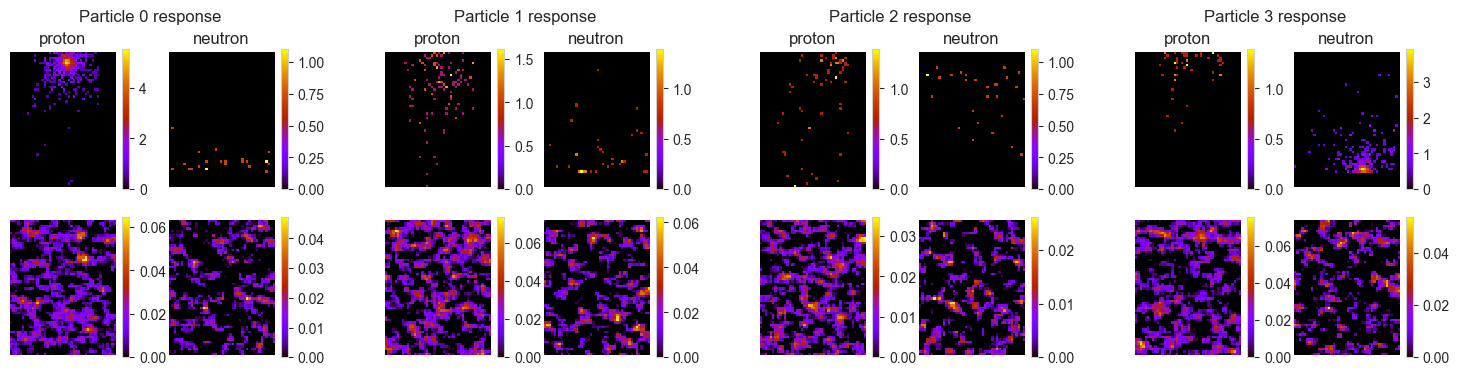

In [43]:
history = train(dataset_with_cond, EPOCHS)

In [ ]:
import seaborn as sns

sns.set_context('notebook', font_scale = 1)

In [ ]:
# total_loss, reconstruction_loss, kl_loss
history_losses = np.array([[float(loss) for loss in losses] for losses in history])

In [ ]:
generator_loss = history_losses[:,0]
disc_loss = history_losses[:,1]
discriminator_r_acc = history_losses[:,2]
discriminator_f_acc = history_losses[:,3]
generator_acc = history_losses[:,4]

In [ ]:
a4_dims = (14, 5)
def print_loss(loss_values, loss_str):
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.lineplot(loss_values)
    plt.xscale('log')
    ax.set_title(f"{loss_str} loss in each epoch")
    ax.set_xlabel("Epoch number")
    ax.set_ylabel(f"{loss_str} loss value")
    # fig.save(f"../images/{EXPERIMENT_NAME}/{loss_str}_loss")

In [ ]:
print_loss(generator_loss, "Generator")
print_loss(disc_loss, "Discriminator")
print_loss(discriminator_r_acc, "Discriminator r accuracy")
print_loss(discriminator_f_acc, "Discriminator f accuracy")
print_loss(generator_acc, "Generator accuracy")